# Implementing a Neural Network from Scratch in Python

In [1]:
# Setup

import sklearn
import sklearn.datasets
import sklearn.linear_model
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Generate a dataset and plot it

#### Dataset generation
`sklearn.datasets.make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)`
- Make two interleaving half circles.
- A simple toy dataset to visualize clustering and classification algorithms. 

#### Plotting

`plt.scatter(x, y, s, c, cmap)`
- A scatter plot of `y` vs `x` with varying marker size and/or color.
    - `x` and `y` define data positions.
    - `s`: size of each data point
    - `c` and `cmap`: color scheme

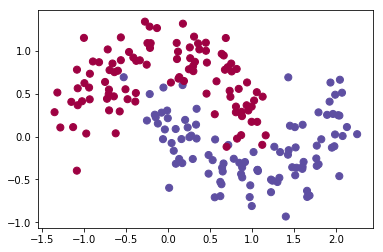

In [2]:
# Generate a dataset and plot it

# Initialize the seed generator
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:, 0], X[:, 1], s=50, c=y, cmap=plt.cm.Spectral)

#### Logistic Regression 

Our goal is to train a classifier that predicts the correct class (red or blue) given the $(x, y)$ coordinates. Since the data is not linearly separable, we should quickly see that, unless we hand-engineering non-linear features (polynomials), linear classifiers such as logistic regressions won't work very well.

`sklearn.linear_model.LogisticRegressionCV(fit_intercept=True, cv=None, penalty='l2')`
- Logistic regression CV (cross-validation) classifier.
- `fit-intercept`: `True` if adding bias.
- `cv`: number of fold for cross-validation.
- `penalty`: string, default to be L2-loss, can be configured to L1-loss by passing in `penalty=l1`.

In [3]:
clf = sklearn.linear_model.LogisticRegressionCV(cv=5)
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

#### Plotting

- `np.meshgrid`: create a rectangular grid out of an array of x values and an array of y values.
- `np.ravel`: flatten out a high-dimensional object to a 1D vector.
- `np.c_`: Translates slice objects to concatenation along the second axis.
- `plt.contourf`: draw contour lines and filled contours

In [4]:
def plot_decision_boundary(pred_func):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01 # padding
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Text(0.5, 1.0, 'Logistic Regression')

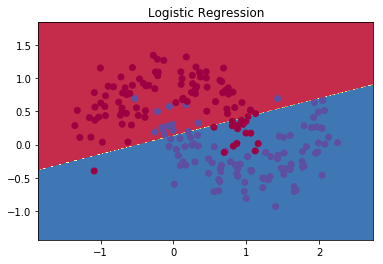

In [5]:
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

As we can see, the logistic regression model failed to capture the "moon" shape of our model.

---
## Neural Network Refresher

#### Decisions we need to make prior to building the model

**Architecture**: simple three-layer NN, input+hidden+output.

**Activation Function**: $\tanh$ (you can choose ReLu or sigmoid also)
- Pros: smooth, stackable, middle section deep derivative thus faster convergence (towards either end).
- Cons: vanishing gradients (but we can ignore this in our simple application).

#### Predicting

Let $x \in \mathbb R^2$ denote an input and $\hat y \in \mathbb R^2$ denote the output.

Let $z_i$ be the weighted sum of inputs of layer $i$ (with bias included) and $a_i$ be the output of layer $i$ (after applying the activation function $\tanh$). 

Let $W_i$ and $b_i$ be parameters of layer $i$ that we want to learn. As a remark, if we use $k$ nodes for our hidden layer, $W_i \in \mathbb R^{2 \times k}$ and $b_i \in \mathbb R^{k}$.

Since we only have three layers,

$$
\begin{align*}
z_1 &= xW_1 + b_1 \\
a_1 &= \tanh(z_1) \\
z_2 &= a_1W_2 + b_2 \\
a_2 = \hat y &= \text{softmax}(z_2)
\end{align*}
$$

#### Some mathematical background

**Softmax function**
$$
\sigma:\mathbb R^k \to \left\{\sigma \in \mathbb R^k \mid \sigma_i > 0, \sum_{i=1}^K \sigma_i = 1 \right\} \\
\sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}, j = 1, \ldots, K
$$

Also known as the "normalized exponential function", which is a generalization of the logistic function that squashes a $k$-dimensional vector $\vec z$ of arbitrary real values to a $k$-dimensional vector $\sigma(z)$ of real values with each entry in the range $(0, 1)$ and all the entries add up to 1. In probability theory, the output of the softmax function can be used to represent a *catagorical distribution*, i.e., a probability distribution over $K$ different possible outcomes.

    
**Cross-entropy loss function** 

If we have $N$ training examples and $C$ class, then the loss for our prediction $\hat y$ with respect to the true label $y$ is given by:

$$
L(y, \hat y) = -\frac{1}{N}\sum_{n\in N}\sum_{i \in C} y_{n, i}\log \hat y_{n, i}
$$

The function sums over our training examples and add to the loss if we predicted the wrong class. The further away $y$ and $\hat y$ are, the greater our loss will be. For more mathematical explanation, visit [here](https://en.wikipedia.org/wiki/Cross_entropy).

**Gradient descent**

The gradient of a scalar function $f(x_1, \ldots, x_n)$ -- denoted $\nabla f$ where $\nabla$ symbol denotes the *vector differential operator* -- packages all its partial derivative information into a vector:
$$
  \nabla f = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \\ \vdots \end{bmatrix}
$$

To find a local minimum of a function using gradient descent, one takes steps proportional to the *negative* of the gradient of the function at the current point.

**Backpropagation**

Backpropagation is an efficient algorithm which gives us a massive speed up when we are computing partial derivatives for gradient descent. It tells us the derivatives of *one output* with respect to *all inputs*, which makes taking derivatives a lot cheapter than what we would normally expect.


#### Learning

To learn the parameters $W_1, W_2, b_1, b_2$, we need to minimize the error (loss) on our training data. A common choice with softmax output is the cross-entropy loss. We use gradient descent to find the minimum of loss function via backpropagation.

We are interested in four values: $\displaystyle \frac{\partial L}{\partial W_1}, \frac{\partial L}{\partial b_1}, \frac{\partial L}{\partial W_2}, \frac{\partial L}{\partial b_2}$:

$$
\begin{align*}
\delta_3 &= \hat y - y \\
\delta_2 &= (1-\tanh^2 z_1) \cdot \delta W_2^T \\
\frac{\partial L}{\partial W_2} &= a_1^T\delta_3 \\
\frac{\partial L}{\partial b_2} &= \delta_3 \\ 
\frac{\partial L}{\partial W_1} &= x^T\delta_2 \\
\frac{\partial L}{\partial b_1} &= \delta_2
\end{align*}
$$

---
## Implementation

In [6]:
num_examples = len(X) # size of the training set
nn_input_dim = 2      # dimension of input layer
nn_output_dim = 2     # dimension of output layer

epsilon = 0.01        # learning rate for gradient descent, arbitrarily picked
reg_lambda = 0.01     # regularization strength, arbitrarily picked

In [7]:
def calculate_loss(model):
    
    """ Helper function to evaluate the total loss on the training set. """
    
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward paragation, refer to the "Predicting" section
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    yhat = np.exp(z2) / np.sum(np.exp(z2), axis=1, keepdims=True) # softmax with the help from numpy vectorized functions
    
    # Calculating the loss and add regularization to prevent overfitting 
    data_loss = np.sum(-np.log(yhat[range(num_examples), y])) # read numpy array selection if this seems unfamiliar
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    return 1./num_examples * data_loss

In [8]:
def predict(model, x):
    
    """ Predict an output (0 or 1) based on the model and input. """
    
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward paragation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    yhat = np.exp(z2) / np.sum(np.exp(z2), axis=1, keepdims=True) 
    
    return np.argmax(yhat, axis=1) # return the most likely class based on the probability

In [9]:
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    """ Learns parameters for the NN and return the model.
        - nn_hdim: number of nodes in the hidden layer.
        - num_passes: number of iterations we want to train.
        - print_loss: if True, print the loss every 1000 iteration. """
    
    # Initialize parameters to random values. We want to learn them through training.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b1 = np.zeros((1, nn_hdim))
    b2 = np.zeros((1, nn_output_dim))
    
    # Return value
    model = {}
    
    # Batch gradient descent
    for i in range(0, num_passes):
        
        # Forward paragation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        yhat = np.exp(z2) / np.sum(np.exp(z2), axis=1, keepdims=True) 
        
        # Backpropagation, refer to the backpropagation section
        delta3 = yhat
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # Regularization terms
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # Update parameters
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
        
    print("Final loss: %f" % calculate_loss(model) )
        
    return model

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068888
Loss after iteration 3000: 0.070752
Loss after iteration 4000: 0.070748
Loss after iteration 5000: 0.070751
Loss after iteration 6000: 0.070754
Loss after iteration 7000: 0.070756
Loss after iteration 8000: 0.070757
Loss after iteration 9000: 0.070758
Loss after iteration 10000: 0.070758
Loss after iteration 11000: 0.070758
Loss after iteration 12000: 0.070758
Loss after iteration 13000: 0.070758
Loss after iteration 14000: 0.070758
Loss after iteration 15000: 0.070758
Loss after iteration 16000: 0.070758
Loss after iteration 17000: 0.070758
Loss after iteration 18000: 0.070758
Loss after iteration 19000: 0.070758
Final loss: 0.071316


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

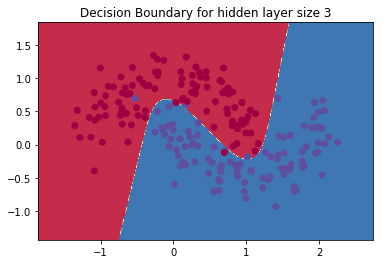

In [10]:
model = build_model(3, print_loss=True)
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

#### Add more layers

In [ ]:
plt.figure(figsize=(16, 32))
dims = [1, 2, 3, 4, 5, 20]
for i, hdim in enumerate(dims):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden layer size %d' % hdim)
    model = build_model(hdim)
    plot_decision_boundary(lambda x: predict(model, x))
    
plt.show()

Final loss: 0.328367
Final loss: 0.354752
Final loss: 0.071316
Final loss: 0.050125
Final loss: 0.039037
Final loss: 0.030735
